<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-28-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [15]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,299691,572790,872481.0
34,NJ,116264,125054,241318.0
21,MA,60265,205353,265618.0
16,IL,50355,206312,256667.0
5,CA,46500,556639,603139.0
41,PA,44366,170517,214883.0
24,MI,40399,131953,172352.0
10,FL,33193,340295,373488.0
20,LA,27660,128908,156568.0
47,TX,27054,287736,314790.0


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [17]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
85,2020-04-16,664129,3424690.0,30722,31017.0,2158.0,0.642815
86,2020-04-17,695761,3582610.0,32785,31632.0,2063.0,0.673432
87,2020-04-18,723776,3724925.0,34557,28015.0,1772.0,0.700548
88,2020-04-19,751287,3891383.0,36224,27511.0,1667.0,0.727176
89,2020-04-20,776419,4038895.0,37913,25132.0,1689.0,0.751501
90,2020-04-21,802330,4186974.0,40471,25911.0,2558.0,0.776581
91,2020-04-22,830223,4501156.0,42508,27893.0,2037.0,0.803579
92,2020-04-23,861788,4693168.0,44385,31565.0,1877.0,0.834131
93,2020-04-24,896306,4925393.0,46251,34518.0,1866.0,0.867541
94,2020-04-25,932242,5196649.0,48069,35936.0,1818.0,0.902324


In [18]:
dfCAPos[-7:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
50,2020-04-23,37369,482097.0,1469,1973.0,115.0,0.803634
51,2020-04-24,39254,494173.0,1562,1885.0,93.0,0.844172
52,2020-04-25,41137,506035.0,1651,1883.0,89.0,0.884667
53,2020-04-26,42164,526084.0,1710,1027.0,59.0,0.906753
54,2020-04-27,43464,553409.0,1755,1300.0,45.0,0.934710
55,2020-04-28,45031,577608.0,1809,1567.0,54.0,0.968409
56,2020-04-29,46500,603139.0,1887,1469.0,78.0,1.000000


In [19]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-25,932242,4264407,5315,56344.0,99099.0,15020.0,2516.0,5266.0,227.0,112783.0,48069,99099.0,5201964,5196649.0,5196649.0,1818.0,2422.0,235320.0,35936.0,271256.0
2020-04-26,959258,4443794,4445,55050.0,101233.0,14831.0,2571.0,5121.0,227.0,116801.0,49164,101233.0,5407497,5403052.0,5403052.0,1095.0,2134.0,179387.0,27016.0,206403.0
2020-04-27,981134,4612361,4077,54971.0,104249.0,9655.0,3720.0,4867.0,195.0,121609.0,50327,104249.0,5597572,5593495.0,5593495.0,1163.0,3307.0,168567.0,21876.0,190443.0
2020-04-28,1005592,4790136,4206,54940.0,106308.0,9491.0,3798.0,4760.0,195.0,139342.0,52525,106308.0,5799934,5795728.0,5795728.0,2198.0,2059.0,177775.0,24458.0,202233.0
2020-04-29,1033157,4993013,4832,54930.0,109690.0,9612.0,4093.0,4796.0,365.0,147484.0,55225,109690.0,6031002,6026170.0,6026170.0,2700.0,3382.0,202877.0,27565.0,230442.0


In [20]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-25,41137,464898,0,4847.0,0.0,1458.0,0.0,0.0,0.0,0.0,1651,0.0,506035,506035.0,506035.0,89.0,0.0,9979.0,1883.0,11862.0
2020-04-26,42164,483920,0,4928.0,0.0,1473.0,0.0,0.0,0.0,0.0,1710,0.0,526084,526084.0,526084.0,59.0,0.0,19022.0,1027.0,20049.0
2020-04-27,43464,509945,0,4878.0,0.0,1499.0,0.0,0.0,0.0,0.0,1755,0.0,553409,553409.0,553409.0,45.0,0.0,26025.0,1300.0,27325.0
2020-04-28,45031,532577,0,4983.0,0.0,1485.0,0.0,0.0,0.0,0.0,1809,0.0,577608,577608.0,577608.0,54.0,0.0,22632.0,1567.0,24199.0
2020-04-29,46500,556639,0,5011.0,0.0,1512.0,0.0,0.0,0.0,0.0,1887,0.0,603139,603139.0,603139.0,78.0,0.0,24062.0,1469.0,25531.0


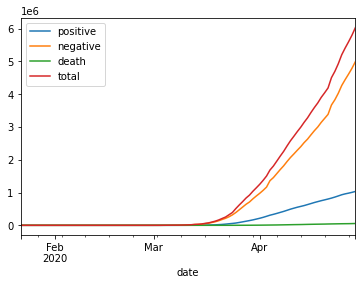

In [21]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [22]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-16,604070,25871
2020-04-17,632781,28221
2020-04-18,665330,30384
2020-04-19,695353,32427
2020-04-20,723605,34203
2020-04-21,751273,35884
2020-04-22,776907,37602
2020-04-23,800926,40073
2020-04-24,830053,42311


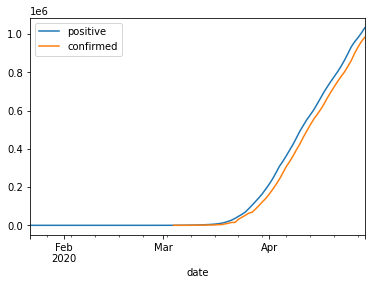

In [23]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [24]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-23,37369,444728,0,4929.0,0.0,1531.0,0.0,0.0,0.0,0.0,1469,0.0,482097,482097.0,482097.0,115.0,0.0,14797.0,1973.0,16770.0
2020-04-24,39254,454919,0,4880.0,0.0,1521.0,0.0,0.0,0.0,0.0,1562,0.0,494173,494173.0,494173.0,93.0,0.0,10191.0,1885.0,12076.0
2020-04-25,41137,464898,0,4847.0,0.0,1458.0,0.0,0.0,0.0,0.0,1651,0.0,506035,506035.0,506035.0,89.0,0.0,9979.0,1883.0,11862.0
2020-04-26,42164,483920,0,4928.0,0.0,1473.0,0.0,0.0,0.0,0.0,1710,0.0,526084,526084.0,526084.0,59.0,0.0,19022.0,1027.0,20049.0
2020-04-27,43464,509945,0,4878.0,0.0,1499.0,0.0,0.0,0.0,0.0,1755,0.0,553409,553409.0,553409.0,45.0,0.0,26025.0,1300.0,27325.0
2020-04-28,45031,532577,0,4983.0,0.0,1485.0,0.0,0.0,0.0,0.0,1809,0.0,577608,577608.0,577608.0,54.0,0.0,22632.0,1567.0,24199.0
2020-04-29,46500,556639,0,5011.0,0.0,1512.0,0.0,0.0,0.0,0.0,1887,0.0,603139,603139.0,603139.0,78.0,0.0,24062.0,1469.0,25531.0


In [25]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1012582
dead           58355
dtype: int64

In [26]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    46164
dead          1864
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [28]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1012582
Spain              232128
Italy              201505
France             169053
United Kingdom     162350
Germany            159912
Turkey             114653
Russia              93558
Iran                92584
China               83940
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [33]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-04-29,33193,1240,33193,1.000000
FL,2020-04-28,32846,1154,33193,0.989546
FL,2020-04-27,32138,1101,33193,0.968216
FL,2020-04-26,31528,1094,33193,0.949839
FL,2020-04-25,30839,1075,33193,0.929081
FL,2020-04-24,30174,1031,33193,0.909047
FL,2020-04-23,28832,979,33193,0.868617


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

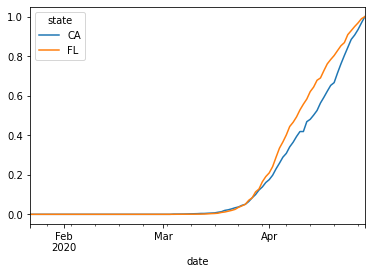

In [35]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

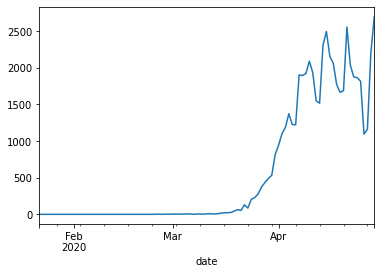

In [37]:
x = dfCovidtracking.groupby(by='date')
#y=x.positive.plot.line()
y1=x.sum().deathIncrease.plot.line()

In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [39]:
dfByWeekYear.sum()[:-1]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202004,0.0,0.0,0.0,0.0,0.0
202005,0.0,0.0,0.0,0.0,0.0
202006,0.0,0.0,0.0,1.0,1.0
202007,0.0,0.0,0.0,0.0,0.0
202008,0.0,0.0,0.0,0.0,0.0
202009,8.0,0.0,81.0,28.0,109.0
202010,23.0,0.0,2821.0,595.0,3416.0
202011,46.0,0.0,30203.0,4114.0,34317.0
202012,359.0,2498.0,179297.0,31482.0,210779.0
202013,2091.0,13766.0,497952.0,107963.0,605915.0


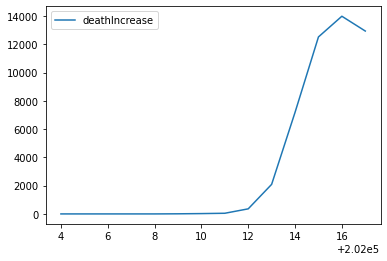

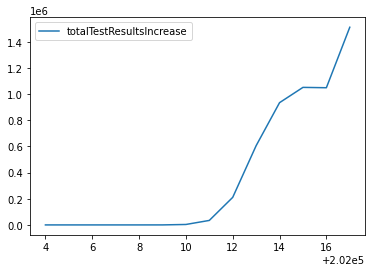

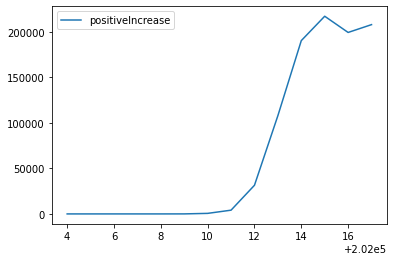

In [40]:
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line()
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line()
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line()

In [41]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
544,FL,2020-04-29,33193,1240,33193,1.000000
545,FL,2020-04-28,32846,1154,33193,0.989546
546,FL,2020-04-27,32138,1101,33193,0.968216
547,FL,2020-04-26,31528,1094,33193,0.949839
548,FL,2020-04-25,30839,1075,33193,0.929081
549,FL,2020-04-24,30174,1031,33193,0.909047
550,FL,2020-04-23,28832,979,33193,0.868617
551,FL,2020-04-22,28309,910,33193,0.852861
552,FL,2020-04-21,27495,856,33193,0.828337
553,FL,2020-04-20,26660,806,33193,0.803181


In [42]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct
3046,WY,2020-04-26,362,7,536,0.675373


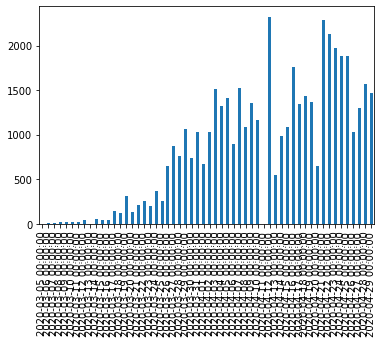

In [43]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [46]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive    1033157
negative    4993013
pending        4832
death         55225
total       6031002
dtype: int64
Current Infection Rate 17.130769%
Percentage of US affected: 0.331582%
Percentage of US tested/affected: 1.852731%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [54]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.540546,4.484942
NJ,1.308956,2.716875
MA,0.874356,3.853723
RI,0.778488,5.679367
CT,0.750767,2.659477
LA,0.594993,3.367927
DC,0.581793,2.724623
DE,0.478042,2.211830
MI,0.404522,1.725788


In [55]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 1.835906%


In [56]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [58]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14092 entries, 0 to 14091
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  13907 non-null  object 
 1   location                  14092 non-null  object 
 2   date                      14092 non-null  object 
 3   total_cases               14092 non-null  int64  
 4   new_cases                 14092 non-null  int64  
 5   total_deaths              14092 non-null  int64  
 6   new_deaths                14092 non-null  int64  
 7   total_cases_per_million   13804 non-null  float64
 8   new_cases_per_million     13804 non-null  float64
 9   total_deaths_per_million  13804 non-null  float64
 10  new_deaths_per_million    13804 non-null  float64
 11  total_tests               3462 non-null   float64
 12  new_tests                 3082 non-null   float64
 13  total_tests_per_thousand  3462 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [60]:
dfOwidTests.date.max()

'2020-04-29'

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [62]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    5795728.0
RUS    3303717.0
DEU    2547052.0
ITA    1910761.0
ESP    1035522.0
         ...    
CRI       9621.0
PRY       8429.0
MMR       7718.0
ZWE       7287.0
BOL       6121.0
Name: total_tests, Length: 82, dtype: float64

In [63]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 21363097
Total tests done in USA : 5795728
How many more times has the world tested more than the US: 3.7


In [64]:
dfOwid.iso_code.nunique()

207